In [1]:
import os
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib as mpl

#For editable text. Except latex text is still shapes sadly
mpl.rcParams['pdf.fonttype'] = 42
mpl.rcParams['ps.fonttype'] = 42
sns.set_style("whitegrid")
font = {'size' : 15}
lines = {'linewidth' : 0.5}
fig = {'figsize' : (2.5, 1.5)}
mpl.rc('font', **font)
mpl.rc('lines', **lines)
mpl.rc('figure', **fig)

from sklearn.preprocessing import RobustScaler
from scipy.stats import mannwhitneyu

# Set style
sns.set(style = "whitegrid", palette = "pastel",
        color_codes=True)

import cfrna_methods as toolkit

/Users/sevahn/anaconda3/lib/python3.11/site-packages/pandas/core/arrays/masked.py:60: UserWarning: Pandas requires version '1.3.6' or newer of 'bottleneck' (version '1.3.5' currently installed).
  from pandas.core import (


In [2]:
biofluid_pal = {}
biofluid_pal['sediment'] = "#97D9E1"
biofluid_pal['supt'] = "#3F9ED9"
biofluid_pal['plasma'] = "#f1593c" # '#bee9e8'
biofluid_pal[1] = '#1b4965'
biofluid_pal[0] = '#f20089'

biofluid_pal['female_ctrl'] = "#ffafcc"
biofluid_pal['female_stone'] = '#f20089'
biofluid_pal['male_ctrl'] = "#bde0fe"
biofluid_pal['male_stone'] = '#1b4965'

biofluid_pal['male_dummy'] = 'cyan'
biofluid_pal['blank'] = 'cyan'


In [3]:
def save_figure_pdf(fig, path_to_save):
	'''
	Utility fxn to save a figure without having to retype all the required options.
	Input:
		fig - a matplotlib.pyplot.figure instance with the figure you'd like to save
		path_to_save - the path you'd like to save the figure to
	Returns: Nothing but there should now be a pdf version in 300 dpi with a transparent bkg at path_to_save
	'''
	fig.savefig(path_to_save, dpi = 300,
                bbox_inches = 'tight', transparent = True)

# acquire counts and signatures

In [4]:
# get the metadata
urineonly_meta = '../data/diffex/urine_only_meta_diffex.csv'

In [5]:
urine_logCPM = toolkit.logcpm_tmm("../data/20231228_filtered_sed_supt_urineONLY.csv",
                                      "../data/diffex/urine_only/20231228_urineOnly_TMM.csv")

# get the metadata
urineonly_meta = '../data/diffex/urine_only_meta_diffex.csv'
urineOnly_meta = pd.read_csv(urineonly_meta)

[ True]


In [6]:
cell_sig_df = pd.read_csv("../data/rna_seq_cts/celltype_sigs.csv")
allSigs = {}
for ct in cell_sig_df.columns:
    allSigs[ct] = cell_sig_df[ct].dropna().values.tolist()

# comparison of prostate gene expression

In [7]:
females = np.unique(urineOnly_meta[urineOnly_meta.sex == 0].patient_id.values)

In [8]:
females

array(['1741', '1754', '1755', '1757'], dtype=object)

In [9]:
female_samps = []
for f in females:
    for samp in urine_logCPM.columns:
        if f in samp: 
            female_samps += [samp]

# urine sediment vs. supt comparison

In [10]:
# check if x1,x2/n is the equivalent of total/n
def sigScore(cts_df, sample_id):
    sigScoreDF = pd.DataFrame(index = cts_df.columns)
    
    
    for ct in allSigs:
        gene_intersection = np.intersect1d(cts_df.index.get_level_values(0),
                                           allSigs[ct])

        sigScore = cts_df.loc(axis = 0)[gene_intersection, :] 
        
        if sigScore.shape[0] < 5: continue
        sigScore = sigScore.sum(axis = 0).to_frame()
        cellSigScore = sigScore / len(gene_intersection)
        
    
        cellSigScore.columns = [ct]

        sigScoreDF = sigScoreDF.join(cellSigScore)
    
    return(sigScoreDF)

In [11]:
sed_id = [i for i in urine_logCPM.columns if 'sediment' in i]
supt_id = [i for i in urine_logCPM.columns if 'supt' in i]

In [12]:
urine_rawSigs  = sigScore(urine_logCPM,
                        sed_id + supt_id)

In [13]:
urine_rawSigs['sample'] = urine_rawSigs.index

In [14]:
samp_id = [i.split("_")[0] for i in urine_rawSigs['sample']]

In [15]:
sex_id = []
for samp in samp_id:
    sex = urineOnly_meta[urineOnly_meta.patient_id == samp]['sex'].drop_duplicates(keep = 'first')
    
    sex_id += sex.values.tolist()

In [16]:
urine_rawSigs['sex'] = sex_id
urine_rawSigs['biofluid'] = ['supt' if 'supt' in i else 'sediment' for i in urine_rawSigs.index]
print("urine_rawSigs columns: ", urine_rawSigs.head().columns)

melted_urineRawSigs = pd.melt(urine_rawSigs,
                              id_vars = ['biofluid', 'sample', 'sex'],
                              value_vars = urine_rawSigs.columns[:-3])

melted_urineRawSigs['variable'] = [i.capitalize() for i in melted_urineRawSigs['variable']]



urine_rawSigs columns:  Index(['bladder urothelial cell', 'LE', 'Proximal tubule', 'sample', 'sex',
       'biofluid'],
      dtype='object')


In [17]:
melted_urineRawSigs['biofluid_ct'] =  melted_urineRawSigs['variable'] + "_" + melted_urineRawSigs.biofluid

In [18]:
melted_urineRawSigs = melted_urineRawSigs.sort_values(by = 'biofluid_ct')

In [19]:
def compare_sed_supt(ct): 
    urine_rawSigs['biofluid'] = ['sediment' if 'sediment' in i else 'supt' for i in urine_rawSigs.index]
    
    # subset to male only if prostate cells
    if ct == "LE":
        comparison_subset = urine_rawSigs[urine_rawSigs.sex == 1]
    
    else: comparison_subset = urine_rawSigs
    
    ct_urine = comparison_subset[[ct, 'biofluid']]
    sed_ct = ct_urine[ct_urine.biofluid == 'sediment'][ct]
    supt_ct = ct_urine[ct_urine.biofluid != 'sediment'][ct]
    print("num sed", len(sed_ct))
    print("num supt ", len(supt_ct))
    print(mannwhitneyu(sed_ct, supt_ct,
                      alternative = 'two-sided'))

In [20]:
compare_sed_supt('bladder urothelial cell')

num sed 17
num supt  13
MannwhitneyuResult(statistic=106.0, pvalue=0.8670498125862652)


In [21]:
compare_sed_supt('LE')

num sed 13
num supt  11
MannwhitneyuResult(statistic=21.0, pvalue=0.00376957206341765)


In [22]:
compare_sed_supt('Proximal tubule')

num sed 17
num supt  13
MannwhitneyuResult(statistic=103.0, pvalue=0.769550997768075)


In [23]:
for i in np.unique(melted_urineRawSigs.biofluid_ct):
    print(i)
    if 'sed' in i:
        biofluid_pal[i] = biofluid_pal['sediment']
    else:
        biofluid_pal[i] = biofluid_pal['supt']

Bladder urothelial cell_sediment
Bladder urothelial cell_supt
Le_sediment
Le_supt
Proximal tubule_sediment
Proximal tubule_supt


In [24]:
for i in np.unique(melted_urineRawSigs.variable):
    dummy_entry = i + "_blank"
    vals = ['blank', 'dummy', 1, i, 3, dummy_entry]
    biofluid_pal[dummy_entry] = '#FFFFFF'  

In [25]:
for i in np.unique(melted_urineRawSigs.variable):
    dummy_entry = i + "_blank"
    
    # make an entry value that's easy to delete in the middle of the y-axis range
    vals = ['blank', 'dummy', 1, i, 3, dummy_entry]
    
    # make it all white
    biofluid_pal[dummy_entry] = '#FFFFFF'
    
    # in place modify df
    melted_urineRawSigs.loc[len(melted_urineRawSigs.index)] = vals

In [26]:
melted_urineRawSigs['condition'] = ['ctrl' if 'N' in i else "dummy" if i == 'dummy' else "stone" for i in melted_urineRawSigs['sample']]
melted_urineRawSigs['gender'] = ['male' if i == 1 else "female" for i in melted_urineRawSigs['sex']]
melted_urineRawSigs['gender_status'] = melted_urineRawSigs['gender'] + "_" + melted_urineRawSigs['condition']              

In [27]:
np.unique(melted_urineRawSigs['gender_status'])

array(['female_stone', 'male_ctrl', 'male_dummy', 'male_stone'],
      dtype=object)

In [28]:
biofluid_order = ['sediment', 'supt', 'blank']
celltypes = ['Proximal tubule', 'Bladder urothelial cell', 'Le'] 

ct_order_lst = []

for ct in celltypes:
    for j in biofluid_order:
        if ct == 'Enterocyte' and j == 'blank': continue
        ct_order_lst += [f'{ct}_{j}']

In [29]:
melted_urineRawSigs['gender'] = ['male' if i == 1 else "female" for i in melted_urineRawSigs['sex']]
melted_urineRawSigs['gender_status'] = melted_urineRawSigs['gender'] + "_" + melted_urineRawSigs['condition']              

In [30]:
controls = melted_urineRawSigs[melted_urineRawSigs.condition == "ctrl"]
stone = melted_urineRawSigs[melted_urineRawSigs.condition == "stone"]

In [31]:
ct_order_lst = ct_order_lst[:-1] # remove "Le_blank" so plot ends on "Le_supt"

/Users/sevahn/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/Users/sevahn/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/Users/sevahn/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/Users/sevahn/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1075: FutureWarning: When grouping with a length-1 l

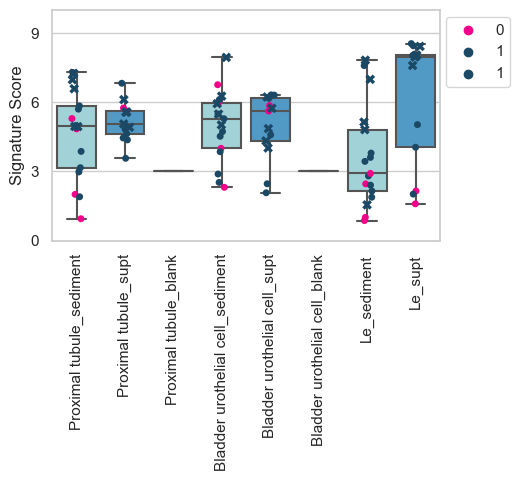

In [32]:
plt.figure(figsize = (5, 3))

sns.boxplot(data = melted_urineRawSigs,
           x = 'biofluid_ct',
            y = 'value',
           fliersize = 0,
           palette = biofluid_pal,
           order = ct_order_lst)

sns.stripplot(data = stone,
           x = 'biofluid_ct',
            y = 'value',
           hue = 'sex',
              size = 5,
              marker = "o",
             palette = biofluid_pal,
             order = ct_order_lst)

sns.stripplot(data = controls,
           x = 'biofluid_ct',
            y = 'value',
           hue = 'sex',
              size = 7,
              marker = "X",
             
            palette = biofluid_pal,
             order = ct_order_lst)

plt.xticks(rotation = 'vertical');
plt.legend(bbox_to_anchor = (1.2, 1));
plt.ylabel('Signature Score');
plt.xlabel("")
plt.yticks([0, 3, 6, 9])
plt.ylim((0, 10))

save_figure_pdf(plt, '../figures/manu_figs/sigScore_urineOnly.pdf')

# get the intestinal markers

In [33]:
markers = ['MUC2', 'ANPEP']

In [34]:
intest_markers = urine_logCPM.loc(axis = 0)[:, markers].T
intest_markers['biofluid'] = ['sediment' if 'sed' in i else 'supt' for i in intest_markers.index]
intest_markers['status'] = ['normal' if i[0] == 'N' else 'stone' for i in intest_markers.index]

In [35]:
melted_intestMarkers = pd.melt(intest_markers, 
        value_vars = intest_markers.columns[:-2].tolist(),
       id_vars = intest_markers.columns[-2:].tolist())

/Users/sevahn/anaconda3/lib/python3.11/site-packages/seaborn/categorical.py:166: FutureWarning: Setting a gradient palette using color= is deprecated and will be removed in version 0.13. Set `palette='dark:black'` for same effect.
  warnings.warn(msg, FutureWarning)
/Users/sevahn/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/Users/sevahn/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/Users/sevahn/anaconda3/lib/python3.11/site-packages/seaborn/categorical.py:166: FutureWarning: Setting a gradient palette using color= is deprecated and will be removed in version 

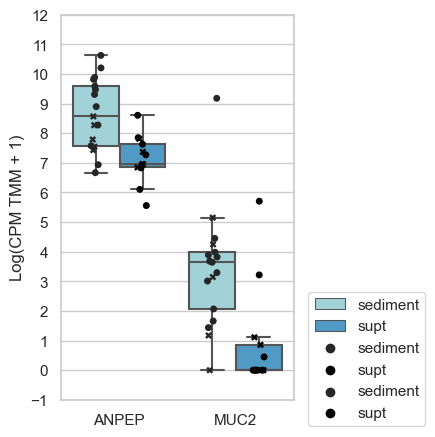

In [36]:
gene_subset = ['ANPEP', 'MUC2']
subset = melted_intestMarkers[melted_intestMarkers['gene_name'].isin(gene_subset)]
plt.figure(figsize = (3, 5))

sns.boxplot(data = subset,
           x = 'gene_name', y = 'value', 
            hue = ('biofluid', ''),
           palette = biofluid_pal,
           dodge = True,
            order = gene_subset,
           fliersize = 0)

stone = melted_intestMarkers[melted_intestMarkers[('status', '')] == "stone"]
ctrl = melted_intestMarkers[melted_intestMarkers[('status', '')] == "normal"]


sns.stripplot(data = stone,
            x = 'gene_name', y = 'value', 
            hue = ('biofluid', ''),
              dodge = True,
              size = 5,
              marker = "o",
              color = "black",
              order = gene_subset)


sns.stripplot(data = ctrl,
            x = 'gene_name', y = 'value', 
            hue = ('biofluid', ''),
              dodge = True,
            size = 5,
            marker = "X",
              color = "black",
              order = gene_subset)

plt.legend(bbox_to_anchor = (1.6, 0.3))
plt.xlabel("");

plt.yticks(np.arange(-1, 13, 1.0))
plt.ylabel('Log(CPM TMM + 1)');

save_figure_pdf(plt, '../figures/manu_figs/intestinal_markers_inUrine.pdf')

In [37]:
ANPEP = melted_intestMarkers[melted_intestMarkers.gene_name == 'ANPEP']
ANPEP_sediment = ANPEP[ANPEP[('biofluid', '')] == 'sediment'].value.tolist()
ANPEP_supt = ANPEP[ANPEP[('biofluid', '')] == 'supt'].value.tolist()

In [38]:
MUC2 = melted_intestMarkers[melted_intestMarkers.gene_name == 'MUC2']
MUC2_sediment = MUC2[MUC2[('biofluid', '')] == 'sediment'].value.tolist()
MUC2_supt = MUC2[MUC2[('biofluid', '')] == 'supt'].value.tolist()

In [39]:
mannwhitneyu(MUC2_sediment, MUC2_supt, alternative = 'two-sided')

MannwhitneyuResult(statistic=191.0, pvalue=0.0006894338831445325)

In [40]:
mannwhitneyu(ANPEP_sediment, ANPEP_supt, alternative = 'two-sided')

MannwhitneyuResult(statistic=184.0, pvalue=0.0022492708379471915)